## Assignment

### Data Selection and Pre-processing

Completion Date: 9th Feb 2022

<br>

In this assignment, the stock price of Apple (Ticker Symbol: AAPL) has been selected. Time series analysis will be applied on the stock price of Apple, and we will evaluate various techniques to analyze as well as predicts the stock price of Apple.

<br>

*Disclaimer: All investment strategies and investments involve risk of loss.  Nothing in this assginment constitutes professional and/or financial advice.*

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from datetime import date

First, we use the yfinance library to download the stock price of AAPL from Jan 2021 to date.

In [2]:
#define the ticker symbol
tickerSymbol = 'AAPL'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
stock = tickerData.history(period='1d', start='2021-1-1', end='2022-2-9')

#see your data
stock.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-02-02,174.527647,175.656214,173.109456,175.616257,84914300,0.00,0
2022-02-03,174.257984,176.015754,171.900986,172.679993,89418100,0.00,0
2022-02-04,171.679993,174.100006,170.679993,172.389999,82391400,0.22,0
2022-02-07,172.860001,173.949997,170.949997,171.660004,77251200,0.00,0
2022-02-08,171.729996,175.350006,171.429993,174.830002,74829200,0.00,0


We are only consider the daily closing price of the stock. Therefore we will keep only the Close column

<AxesSubplot:title={'center':'Apple Stock Price'}, xlabel='Date'>

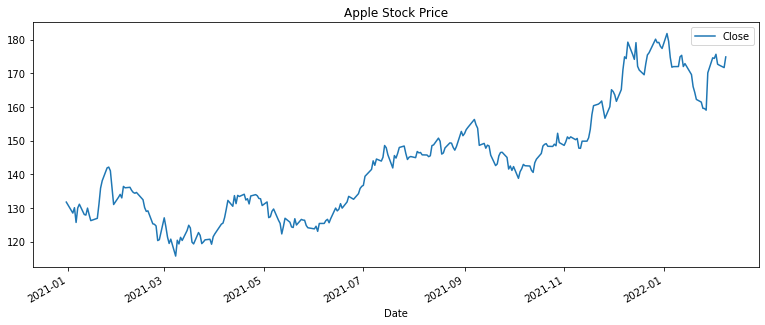

In [3]:
plotsize = (13, 5)
stock.plot(y='Close', figsize=plotsize, title='Apple Stock Price')

### Stationarity of the time series

#### Test 1: we inspect the time series manually. We can see that the stock price of apple:
- Has a clear uptrend. 
- The variance looks pretty consistant at first glance, but we are not sure unless we check the variance quantitatively.
- There is a seasonality component in stock price movement. This is because
    - Sales of the underlying company may fluctuate according to holiday season or macroeconomic factor.
    - According to statistic, stock prices are more likely to fall at Monday and rise at Friday.

Due to the presence of an uptrend, it seems like this is not a stationary series. Lets confirm this by inspect the times series quantitatively

#### Test 2: Summary Statistics & Plots

In [4]:
df_stock = stock['Close']

# split data into 10 chunks
chunks = np.array_split(df_stock, 10)

mean_list = []
variance_list = []

for i in range(0,10):
    mean = chunks[i].mean()
    variance = chunks[i].var()
    mean_list.append(mean)
    variance_list.append(variance)

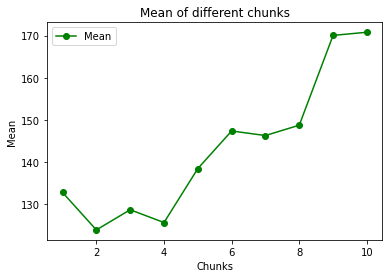

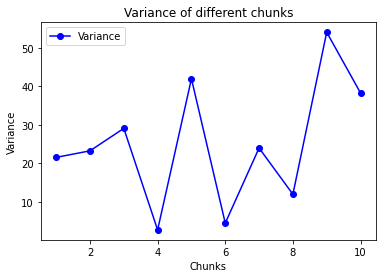

In [5]:
#plot the means for different chunks
from matplotlib import pyplot as plt

chunks_number = [1,2,3,4,5,6,7,8,9,10]

plt.plot(chunks_number, mean_list, color='green', marker='o', linestyle='solid', label = 'Mean')
plt.title("Mean of different chunks")
plt.legend(loc = 'best') 
plt.ylabel("Mean")
plt.xlabel("Chunks")
plt.show()

plt.plot(chunks_number, variance_list, color='blue', marker='o', linestyle='solid', label = 'Variance')
plt.title("Variance of different chunks")
plt.legend(loc = 'best') 
plt.ylabel("Variance")
plt.xlabel("Chunks")
plt.show()

From the 2 graphs above, we can see that the variance and mean flunctuate significantly across different chunks. The time series is not stationary

#### Test 3: Histogram

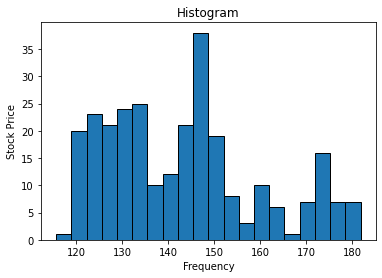

In [6]:
plt.hist(df_stock, edgecolor = "black", bins = 20) 
plt.xlabel('Frequency')
plt.ylabel('Stock Price')
plt.title('Histogram')
plt.show()

It is not normally distributed, which further confirms that this is a non-stationary data

#### Test 4: ADF Test

In [7]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df_stock, regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -0.4894362065117162
p-value: 0.8940615165782453


The p-value is larger than 0.05 which concludes that this is not a stationary data.

## Time Series Forcasting

Next, we will try to build forcast model of AAPL stock price. We will established the model using 3 different approach and investigate the accuracy of the forcast of each model:
- Triple Exponential Smoothing
- ARIMA Model
- Deep Learning


### Exponential Smoothing
Triple exponential smoothing can captures trend & seasonality, which this time series has. Lets check the performance of triple exponential smoothing on this time series

#### Create mytime

In [8]:
# time component
mytime = np.arange(len(df_stock))
np_stock = stock['Close'].to_numpy()

#### There are in total 279 instances. We will take 20% (56) of them as a test set.

In [9]:
test_size = 56
train = np_stock[:-test_size]
test = np_stock[-test_size:]

#### We set the seasonal periods as 80 as perliminary

In [10]:
from statsmodels.tsa.api import ExponentialSmoothing

triple_ex = ExponentialSmoothing(train,
                                  trend="additive",
                                  seasonal="Additive",
                                  seasonal_periods=12).fit(optimized=True)

triple_preds = triple_ex.forecast(len(test))

C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


#### Lets inspect the MSE of the model

In [11]:
def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

triple_mse = mse(test, triple_preds)
print("MSE: ", triple_mse)

MSE:  13209.350883125644


#### Graph Plotting

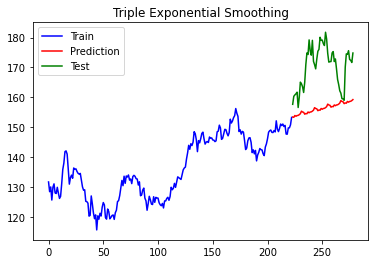

In [12]:
plt.plot(mytime[:-test_size], train, color='blue', linestyle='solid', label = 'Train')
plt.plot(mytime[-test_size:], triple_preds, color='red', linestyle='solid', label = 'Prediction')
plt.plot(mytime[-test_size:], test, color='green', linestyle='solid', label = 'Test')

plt.title("Triple Exponential Smoothing")
plt.legend(loc = 'best') 
plt.show()

#### Lets conduct a grid search to find out the seasonal periods that give the best performance

C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


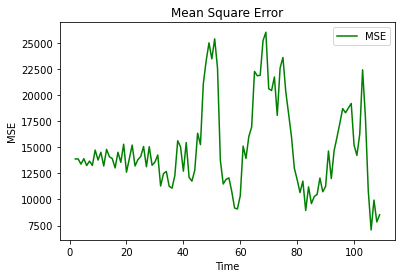

In [13]:
MSE_list = []
seasonal_period = []

for i in range(2,110):
    triple_ex = ExponentialSmoothing(train,
                                  trend="Additive",
                                  seasonal="Additive",
                                  seasonal_periods=i).fit(optimized=True)
    
    triple_preds = triple_ex.forecast(len(test))

    triple_mse = mse(test, triple_preds)
    
    MSE_list.append(triple_mse)
    seasonal_period.append(i)

plt.plot(seasonal_period, MSE_list, color='green', linestyle='solid', label = 'MSE')
plt.title("Mean Square Error")
plt.legend(loc = 'best') 
plt.ylabel("MSE")
plt.xlabel("Time")
plt.show()

Looks like the optimum point lies between 100 to 110. Lets repeat the process with 100 - 110 range to pinpoint exactly where is the optimum point.

C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


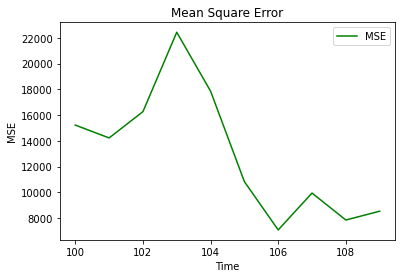

In [14]:
MSE_list = []
seasonal_period = []

for i in range(100,110):
    triple_ex = ExponentialSmoothing(train,
                                  trend="Additive",
                                  seasonal="Additive",
                                  seasonal_periods=i).fit(optimized=True)
    
    triple_preds = triple_ex.forecast(len(test))

    triple_mse = mse(test, triple_preds)
    
    MSE_list.append(triple_mse)
    seasonal_period.append(i)

plt.plot(seasonal_period, MSE_list, color='green', linestyle='solid', label = 'MSE')
plt.title("Mean Square Error")
plt.legend(loc = 'best') 
plt.ylabel("MSE")
plt.xlabel("Time")
plt.show()

Looks like the optimum point is 106. Lets plot out the curve for seasonal_periods = 106

C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


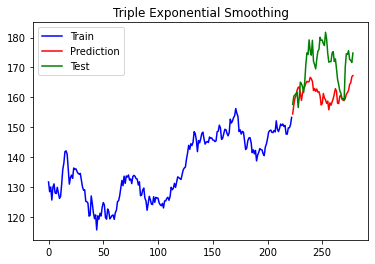

In [15]:
triple_ex = ExponentialSmoothing(train,
                                  trend="additive",
                                  seasonal="Additive",
                                  seasonal_periods=106).fit(optimized=True)

triple_preds = triple_ex.forecast(len(test))

plt.plot(mytime[:-test_size], train, color='blue', linestyle='solid', label = 'Train')
plt.plot(mytime[-test_size:], triple_preds, color='red', linestyle='solid', label = 'Prediction')
plt.plot(mytime[-test_size:], test, color='green', linestyle='solid', label = 'Test')

plt.title("Triple Exponential Smoothing")
plt.legend(loc = 'best') 
plt.show()